# To the model! 🎉

After exploring your data and cleaning it up, it's time to start making some models. Specifically, you may be interested in seeing whether those patterns you detected actually mean something - whether there's any correlation, and whether you can predict what's going on.

## Glorious tools

In general, I use the following libraries for the following methods:
- **Frequentist inferential statistics**: [`statsmodels`](https://www.statsmodels.org/stable/index.html) - e.g. t-tests, ANOVA, linear/logistic regression, regularized regression, generalized linear models
- **Bayesian inferential statistics**:
    - _If you're using conjugate priors_: [`scipy`](https://www.scipy.org/) - e.g. beta-binomial model, Dirichlet
    - _If you're not_: [`pymc3`](http://docs.pymc.io/) - e.g. any MCMC sampling
- **Machine learning**: [`scikit-learn`](http://scikit-learn.org/stable/) - e.g. support vector machines, decision trees/random forests, k-nearest neighbors, clustering
- **Deep learning**: [`keras`](https://keras.io/) - e.g. convolutional neural nets    
    
Of course, there's overlap and redundancy in the above tools. For example, both `statsmodels` and `scikit-learn` have methods for linear and logistic regression. Furthermore, you can actually build _everything_ from scratch in [`numpy`](http://www.numpy.org/) - that is, in Python's linear algebra library. In the beginning, you may want to get started with something like `scikit-learn` because it has (a) [great tutorials](http://scikit-learn.org/stable/tutorial/index.html), (b) intuitive syntax, and (b) almost all the commonly-used methods.

In fact, I'll use one of `scikit-learn`'s excellent learning datasets (since I know it's well-behaved and will actually have results!): [the diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes).

In [1]:
from sklearn import datasets

In [5]:
# sklearn datasets are returned as tuples or dictionaries of the 'data' (the independent variables, the features) 
# and the 'target' (the dependent variable, the thing you want to predict)
X, y = datasets.load_diabetes(return_X_y=True)

# They are returned as numpy arrays, rather than pandas dataframes
X[:1]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613]])

In [10]:
import pandas as pd

# But it's easy to convert them to pandas dataframes, if you prefer
X_df = pd.DataFrame(X)
print(X_df.shape)
X_df.head()

(442, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [13]:
# Our y variable - as a numpy array...
y[:6]

array([151.,  75., 141., 206., 135.,  97.])

In [14]:
# And as a pandas series
y_df = pd.Series(y)
print(y_df.shape)
y_df.head()

(442,)


0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
dtype: float64

## Three ways to do one method: Linear regression

> **Note**

> I'm not going to go through the "typical" modelling workflow of, for example, making a training/test dataset split and running some cross-validation or a grid search to properly tune the hyperparameters. If interested in the modelling workflow, let me know and maybe I can prepare another tutorial!

### Way 1: `scikit-learn`

In [21]:
from sklearn.linear_model import LinearRegression

# Initialize a linear regression object
# (using the default parameters)
lr = LinearRegression()
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# Let's make a training/test split
test_index = X_df.sample(frac=0.2).index

print(f"The size of the test df is {len(test_index)} obs.")
print(f"The size of the training df is {len(X_df) - len(test_index)} obs.")

X_test = X_df.loc[test_index]
y_test = y_df.loc[test_index]

X_train = X_df.loc[~X_df.index.isin(test_index)]
y_train = y_df.loc[~y_df.index.isin(test_index)]

The size of the test df is 88 obs.
The size of the training df is 354 obs.


In [43]:
# Fit the linear regression using our data
# Note: This method changes the LinearRegression() object we made
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
# Let's take a look at the coefficients
lr.coef_

array([  -4.79766744, -192.4470064 ,  581.2823361 ,  294.41729884,
       -484.37614111,  286.01472911,  -40.06535023,  115.56061355,
        603.55339777,   57.17644928])

In [47]:
# How'd we do!?! Let's check our R^2
lr.score(X_test, y_test)

0.5174555966487104

Ooops, not much better than average. I thought this dataset was supposed to be easy!?

In [49]:
# Let's make some predictions for y, compare against the actuals
y_pred = lr.predict(X_test)
y_pred.shape

(88,)

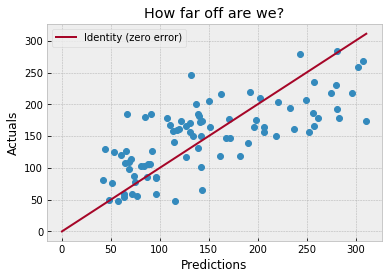

In [62]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('bmh')

max_diagonal_line = max(y_pred.max(), y_test.max())

plt.plot(y_test, y_pred, 'o')
plt.plot([0, max_diagonal_line], [0, max_diagonal_line], label='Identity (zero error)') # Making a 45-degree line, for comparison
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('How far off are we?')
plt.legend()
plt.show()

### Way 2: `statsmodels`

`statsmodels` is built with statisticians in mind: if you're interested in p-values, t-scores and things like that, `statsmodels` will be familiar. It's also a bit more similar to `R`, `Stata`, and other statistical softwares.

In [72]:
import statsmodels.api as sm

# With statsmodels, we need to explicitly add the constant (sklearn does it for us)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
    
X_train.head()

,const,0,1,2,3,4,5,6,7,8,9
0,1.0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,1.0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,1.0,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
4,1.0,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
5,1.0,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346


In [90]:
import numpy as np

# Fit a linear regression
lr_statsmodels = sm.OLS(y_train, X_train)
lr_sm_results = lr_statsmodels.fit()

In [91]:
# How did we do!?!?!?!?
lr_sm_results.rsquared

0.5139381217561377

Same-ish rsquared as `scikit-learn`! i.e. Still pretty bad!

`statsmodels` has some reporting stuff for classical stats stuff:

In [92]:
lr_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     36.27
Date:                Sat, 17 Mar 2018   Prob (F-statistic):           5.04e-48
Time:                        15:05:02   Log-Likelihood:                -1914.0
No. Observations:                 354   AIC:                             3850.
Df Residuals:                     343   BIC:                             3893.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.2487      2.924     52.077      0.000     146.498     157.999
0             -4.7977     68.178     -0.070      0.944    -138.897     129.302
1           -192.4470     68.651     -2.803      0.005    -327.477     -57.417
2            581.2823     74.693      7.782      0.000     434.369     728.196
3            294.4173     75.228      3.914      0.000     146.452     442.383
4           -484.3761    454.532     -1.066      0.287   -1378.398     409.645
5            286.0147    366.132      0.781      0.435    -434.132    1006.162
6            -40.0654    240.898     -0.166      0.868    -513.889     433.758
7            115.5606    183.758      0.629      0.530    -245.873     476.994
8            603.5534    192.804      3.130      0.002     224.327     982.780
9             57.1764     74.452      0.768      0.443     -89.263     203.616
==============================================================================
Omnibus:                        1.845   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.397   Jarque-Bera (JB):                1.600
Skew:                          -0.003   Prob(JB):                        0.449
Kurtosis:                       2.671   Cond. No.                         220.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's predict as well, and plot both the `scikit-learn` and `statsmodels` predictions. That is, let's predict their errors.

In [108]:
y_pred_sm = lr_sm_results.predict(X_test)

# Making a dataframe that compares the actual vs. scikit-learn predictions vs. statsmodels predictions.
comparison_df = pd.DataFrame({'actual': y_test,
             'scikit-learn': y_pred,
             'statsmodels': y_pred_sm})

comparison_df.head()

,actual,scikit-learn,statsmodels
3,206.0,163.546941,163.546941
262,308.0,268.524205,268.524205
325,192.0,219.036425,219.036425
158,96.0,84.332171,84.332171
140,118.0,159.750999,159.750999


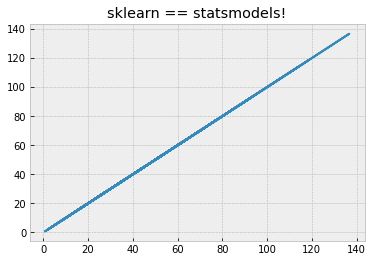

In [114]:
# Let's calculate the absolute errors and plot them

comparison_df['error_sklearn'] = abs(comparison_df['scikit-learn'] - comparison_df['actual'])
comparison_df['error_statsmodels'] = abs(comparison_df['statsmodels'] - comparison_df['actual'])

plt.plot(comparison_df['error_sklearn'], comparison_df['error_statsmodels'])
plt.title('sklearn == statsmodels!')
plt.show()

The main thing we learn from this is that you can use the linear regression tool in either `scikit-learn` and `statsmodels` - both will give you the (exact same) predictions. That is, both will fit to the same coefficients, get the same (well, almost same) $R^2$, and so on. 

This type of overlap doesn't exist for _all_ methods though. As I mentioned, `scikit-learn` goes deeper on **machine learning**, while `statsmodels` goes deeper on **classical (frequentist) statistics**. 

### Way 3: `numpy` (baking from scratch)

All of statistics and machine learning is a series of linear algebra steps. From a simple linear regression to a neural net, you can actually just build it from zero in Python's linear algebra library, `numpy`. (For example, here's [Joel Grus building a neural net in only `numpy` and basic Python - in one hour](https://www.youtube.com/watch?v=o64FV-ez6Gw), and [here's Siraj Raval doing the same thing in 4 minutes](https://www.youtube.com/watch?v=h3l4qz76JhQ).)

This is very useful when you're learning about these methods and you want to take them apart. But it's rare that you'll do it more than once - since there exist so many libraries out there that can reduce the number of steps for you.

Linear regression, though, is one of those methods that takes the same number of steps in any library - since "fitting" a linear regression (i.e. getting your $\beta_{i}$ coefficients for your $i$ independent variables/features) just means minimizing the squared distance between your predictions and the actual values. In [other words](https://en.wikipedia.org/wiki/Linear_regression#Least-squares_estimation_and_related_techniques), 

$$\hat{\beta} = (X^TX)^{-1}(X^Ty)$$

That is:
- Multiplying the $X$ and $y$ matrices (dot product of $X$ transposed and $y$),
- And dividing by the "square" of the $X$ matrix (dot of $X$ transposed and $X$, inverting that)

These are all linear algebra operations!

So we can do it all in `numpy`! But first, let's switch back from `pandas` dataframes to `numpy` arrays:

In [116]:
X_train.head()

,const,0,1,2,3,4,5,6,7,8,9
0,1.0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,1.0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,1.0,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
4,1.0,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
5,1.0,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346


In [131]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# First couple rows
X_train_np[0:2]

array([[ 1.        ,  0.03807591,  0.05068012,  0.06169621,  0.02187235,
        -0.0442235 , -0.03482076, -0.04340085, -0.00259226,  0.01990842,
        -0.01764613],
       [ 1.        , -0.00188202, -0.04464164, -0.05147406, -0.02632783,
        -0.00844872, -0.01916334,  0.07441156, -0.03949338, -0.06832974,
        -0.09220405]])

The linear algebra operations mentioned above - _transpose_, _dot products_, and _inverting a matrix_ - are all `numpy` methods you can do.

In [128]:
# Now the first column (which was our constant) has become our first row
X_train_np.T[0][:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [134]:
# Let's fit our coefficients!
np.dot(X_train_np.T, y_train_np) 

array([54088.        ,   184.88905714,   164.92518334,   807.41457015,
         633.75864179,   251.48702553,   212.75397463,  -563.56415803,
         574.88769823,   714.53280385,   623.67840637])

In [151]:
coefs_ = np.dot(np.linalg.inv(np.dot(X_train_np.T, X_train_np)), np.dot(X_train_np.T, y_train_np))

print("scikit-learn's coefficients")
print(lr.coef_)

print("\nstatsmodel's coefficients")
print(lr_sm_results.params.values[1:])

print("\nnumpy's 'from scratch' coefficients")
print(coefs_[1:])

scikit-learn's coefficients
[  -4.79766744 -192.4470064   581.2823361   294.41729884 -484.37614111
  286.01472911  -40.06535023  115.56061355  603.55339777   57.17644928]

statsmodel's coefficients
[  -4.79766744 -192.4470064   581.2823361   294.41729884 -484.37614111
  286.01472911  -40.06535023  115.56061355  603.55339777   57.17644928]

numpy's 'from scratch' coefficients
[  -4.79766744 -192.4470064   581.2823361   294.41729884 -484.37614111
  286.01472911  -40.06535023  115.56061355  603.55339777   57.17644928]


Given that we have the same coefficients from all three libraries, this means that we would have the same predictions, the same error rate, and the same $R^2$!